<a href="https://colab.research.google.com/github/figarofuga/pixi-test/blob/main/makeshift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# このipynbの使い方

これは、線形計画法を用いて、各個人の希望日・不可日の要望を極力満たすためのScriptです。極力、余計なPackageは使わないようにしています。
以下のショートカットを使うと楽かもしれません。

また、左上の点3つと横線3つのボタンを押すと目次が出るので適宜ご利用ください。

| 内容                                     | ショートカットキー (Windows/macOS) |
|----------------------------------------|-----------------------------------|
| セルの実行                               | Ctrl/Cmd + Enter                  |
| セルの実行 + 次のセルに移動                    | Shift + Enter                     |
| 全セルの実行                               | Ctrl/Cmd + F9                     |
| 現在のセルより上を全て実行                      | Ctrl/Cmd + F8                     |
| 現在のセルより下を全て実行                      | Ctrl/Cmd + F10                    |
| 実行中断                                   | Ctrl/Cmd + M I                    |

> # ⚠ Warning
> 全セルの実行のショートカットをした場合、以下のスクリプトの中で**日毎の割当人数の決定**の当直割当を決めるCode cellでErrorが出ます(Dropdownのボタンを決めた後に`Update DataFrame`ボタンを押す必要があるため)。基本的には、面倒でもShift + Enterで1つずつ押すことを推奨しています。

# Version 2.2.0 (2024/10/15)

+ What's NEW
 - 文章を大きく変更。Major Updateの時は版を決めて保存する事に変更
 - schedule_dfを"Update Dataframe"ボタンを押さなくてもデフォルト値のDataFrameを作成するように変更
 - 割当後のアウトプットを見やすく変更
 - availability_dictを確認出来るように追加
 - shift割り当てのexcelのダウンロード方法を直感的に変更
 - リストや辞書を作成するときにコピーアンドペースト出来るような補助的UIのスクリプトを追加


# Version 1.3.0 (2024/10/11)

+ What's NEW
 - 特定の人物の当直回数を制限するスクリプトを追加

# Version 1.2.0 (2024/10/6)

+ What's NEW
 - 手作業で、特定の人の特定の日付を"不可日"にアップデートするスクリプトを追加


まずは、必須であるortoolsのみインストールします。

**既存のGoogle colabのパッケージとの組み合わせでエラーが出ますが基本的には無視して良いです。デフォルトでOutputを隠しています**。

In [ ]:
%pip install -U -q ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 14.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.6 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
google-cloud-datastore 2.19.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
google-cloud-firestore 2.16.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
tensorb

In [ ]:
#@title 重要な変数の決定

#@markdown ここで、重要な変数を決定します。以下の変数を値を決めたら<font face="Serif" size=5 color='red'> **確実にShift + Enterを押してください** <font>

#@markdown + Google formsの結果をSpreadsheetsにoutputした後のGoogle spreadsheetのURLを入れてください。
df_URL = "https://docs.google.com/spreadsheets/d/1ZDZXCvoGJnZRT37tPhGb1f5oMrzJIf-8A8diCsPCkVk/edit?resourcekey=&gid=1019126080#gid=1019126080"  # @param {"type":"string"}

#@markdown + 当直間のInterval
interval_shifts = "5" # @param [3, 4, 5, 6, 7, 8]
interval_shifts = int(interval_shifts)

#@markdown + Shift回数の最大の人と最小の人の差
diff_in_shifts = 1 # @param [0, 1, 2]
diff_in_shifts = int(diff_in_shifts)

#@markdown + 平日に割り当てるレジデントの最低人数
residents_need_weekday = 1 # @param [0, 1, 2, 3, 4]
residents_need_weekday = int(residents_need_weekday)

#@markdown + 休日に割り当てるレジデントの最低人数
residents_need_weekend = 2 # @param [0, 1, 2, 3, 4]
residents_need_weekend = int(residents_need_weekend)

#@markdown + 平日に割り当てるスタッフの最低人数
staffs_need_weekday = 1 # @param [0, 1, 2, 3, 4]
staffs_need_weekday = int(staffs_need_weekday)

#@markdown + 休日に割り当てるスタッフの最低人数
staffs_need_weekend = 1 # @param [0, 1, 2, 3, 4]
staffs_need_weekend = int(staffs_need_weekend)

#@markdown + 平日に割り当てるstaff + residentの合計人数
all_member_need_weekday = 3 # @param [0, 1, 2, 3, 4, 5, 6, 7]
all_member_need_weekday = int(all_member_need_weekday)

#@markdown + 休日に割り当てるstaff + residentの合計人数
all_member_need_weekend = 4 # @param [0, 1, 2, 3, 4, 5, 6, 7]
all_member_need_weekend = int(all_member_need_weekend)

#@markdown + スタッフの休日の当直割り当て最大回数
staff_holiday_num = 1 # @param [0, 1, 2, 3]
staff_holiday_num = int(staff_holiday_num)

#@markdown + レジデントの休日の当直割り当て最大回数
resident_holiday_num = 2 # @param [0, 1, 2, 3, 4]
resident_holiday_num = int(resident_holiday_num)

# Google spreadsheetの読み込みとGoogle accountのsetup

次に、Google formで集めた回答をGoogle spreadsheetにアウトプットしたものを読み込んで整形する必要があります。Google spreadsheetのデータの読み込みの為には、Google driveから読み込みを許可しないといけません(セキュリティの問題)。
Scriptを実施すると以下に示したような、認証画面がポップアップで出てきます。認証して下さい。

これはこのjupyter notebookを実行する度に必要です。

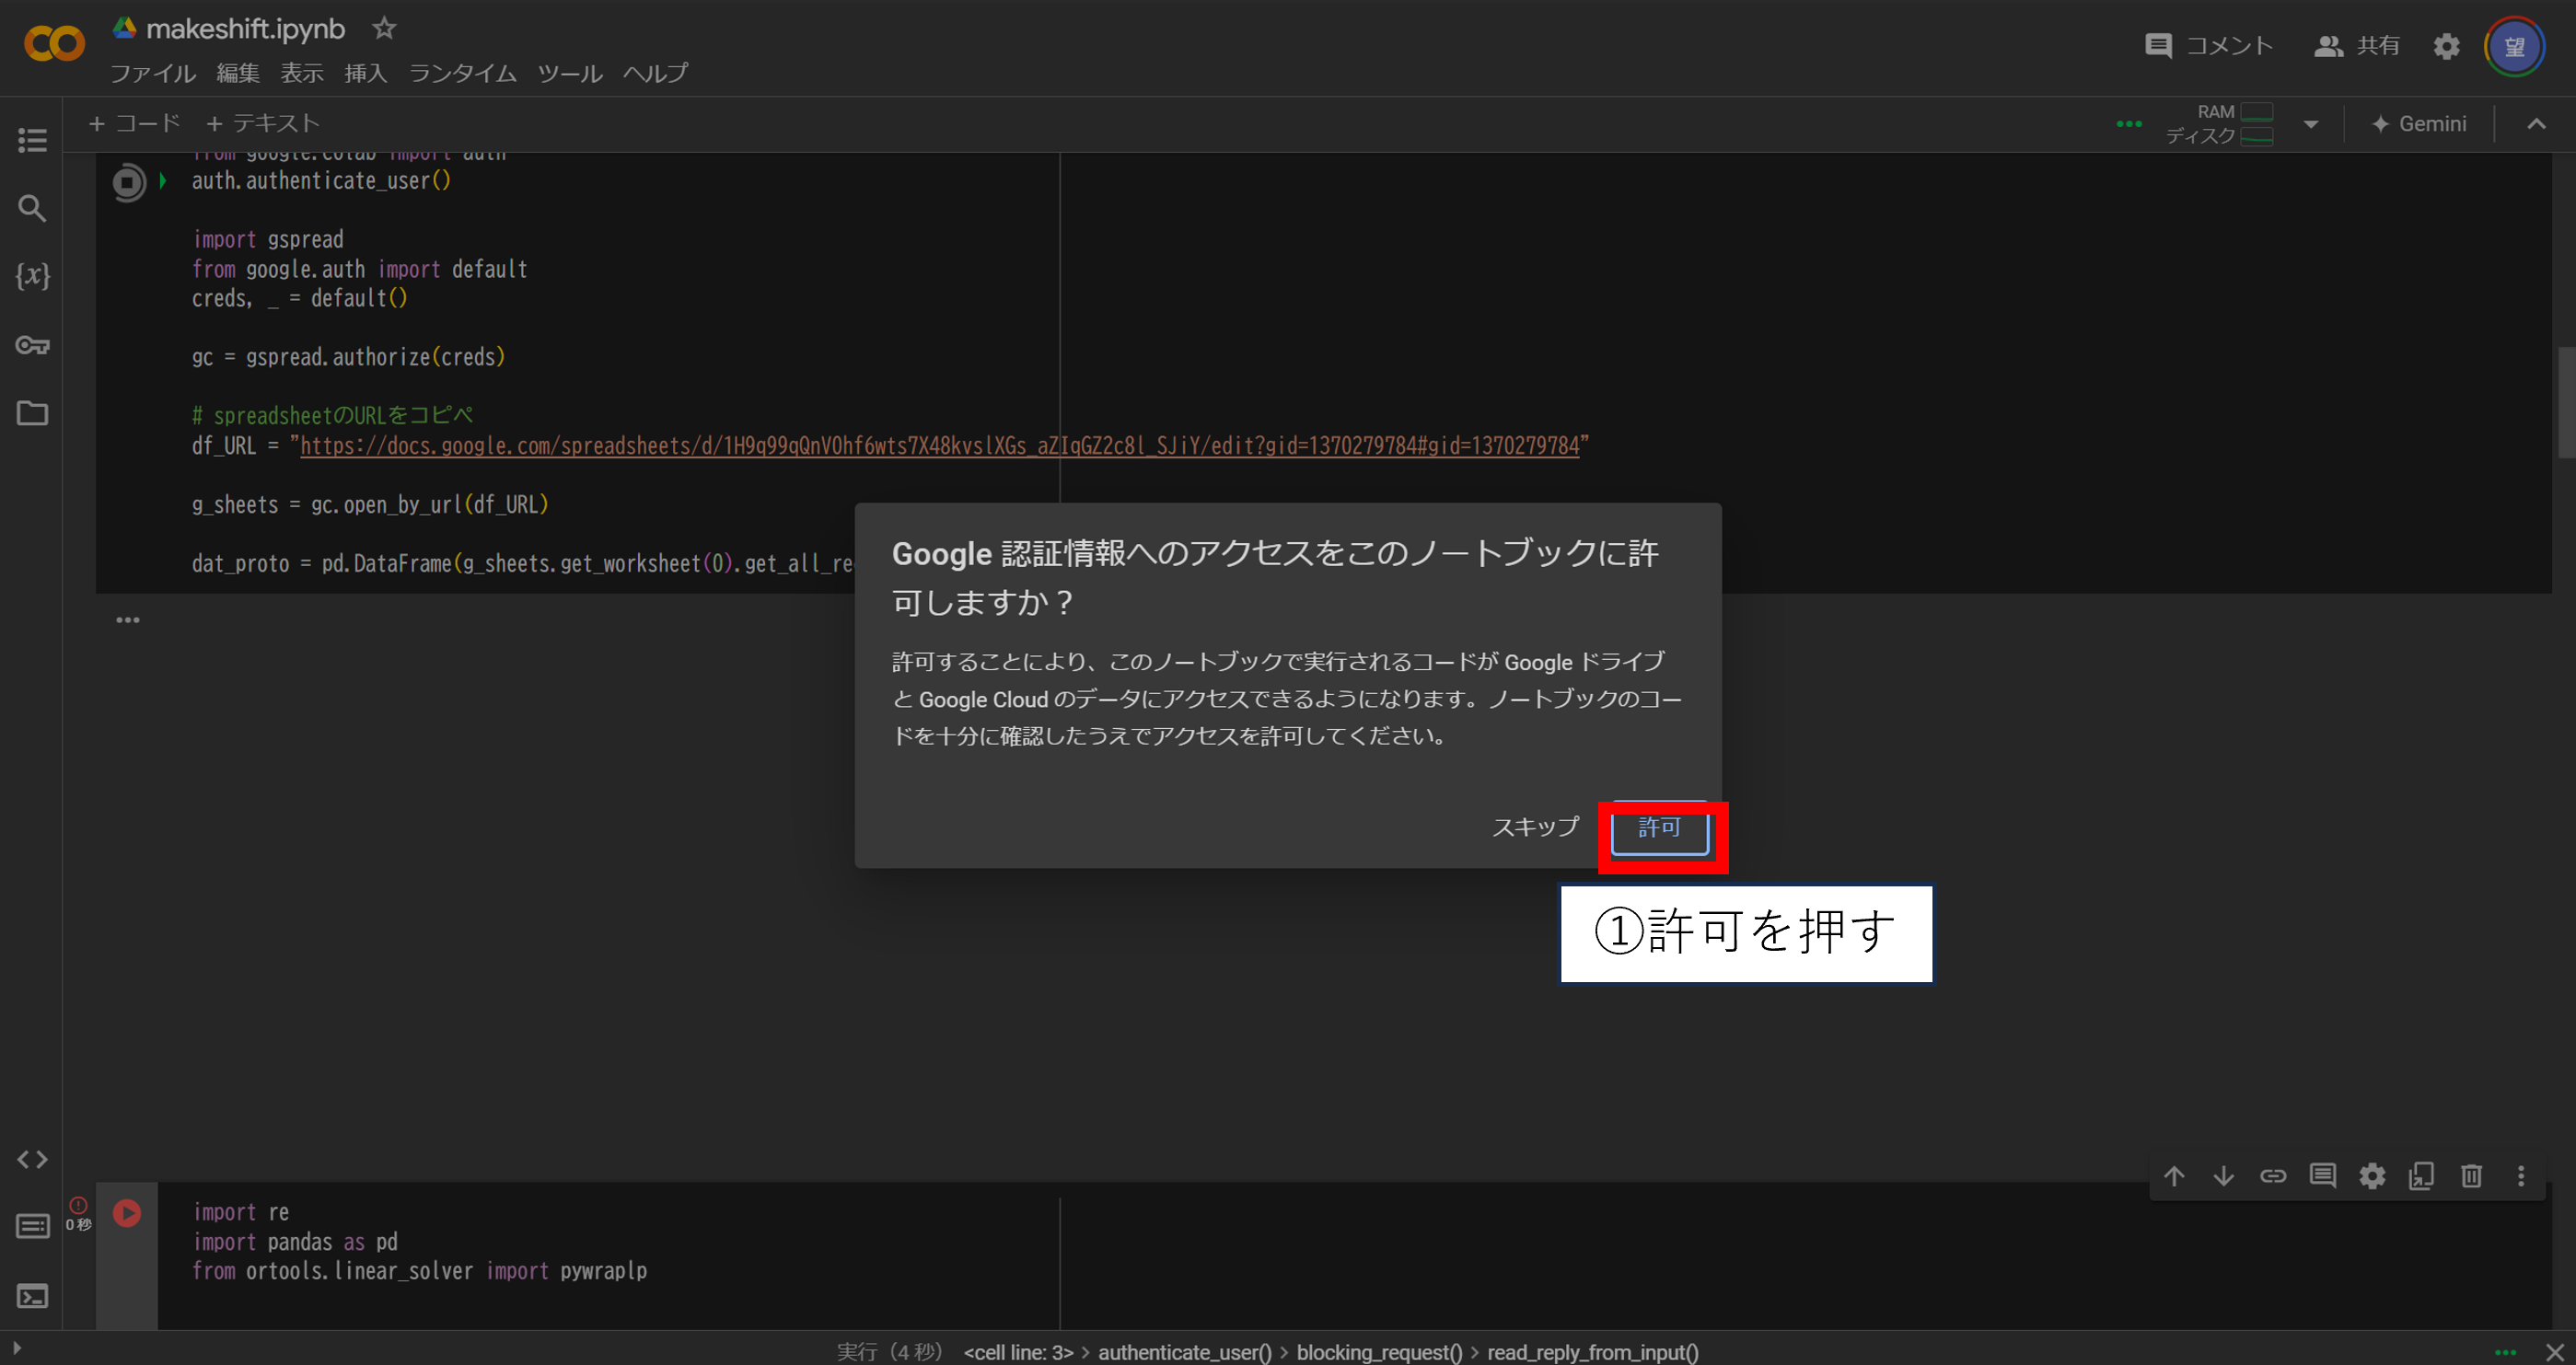

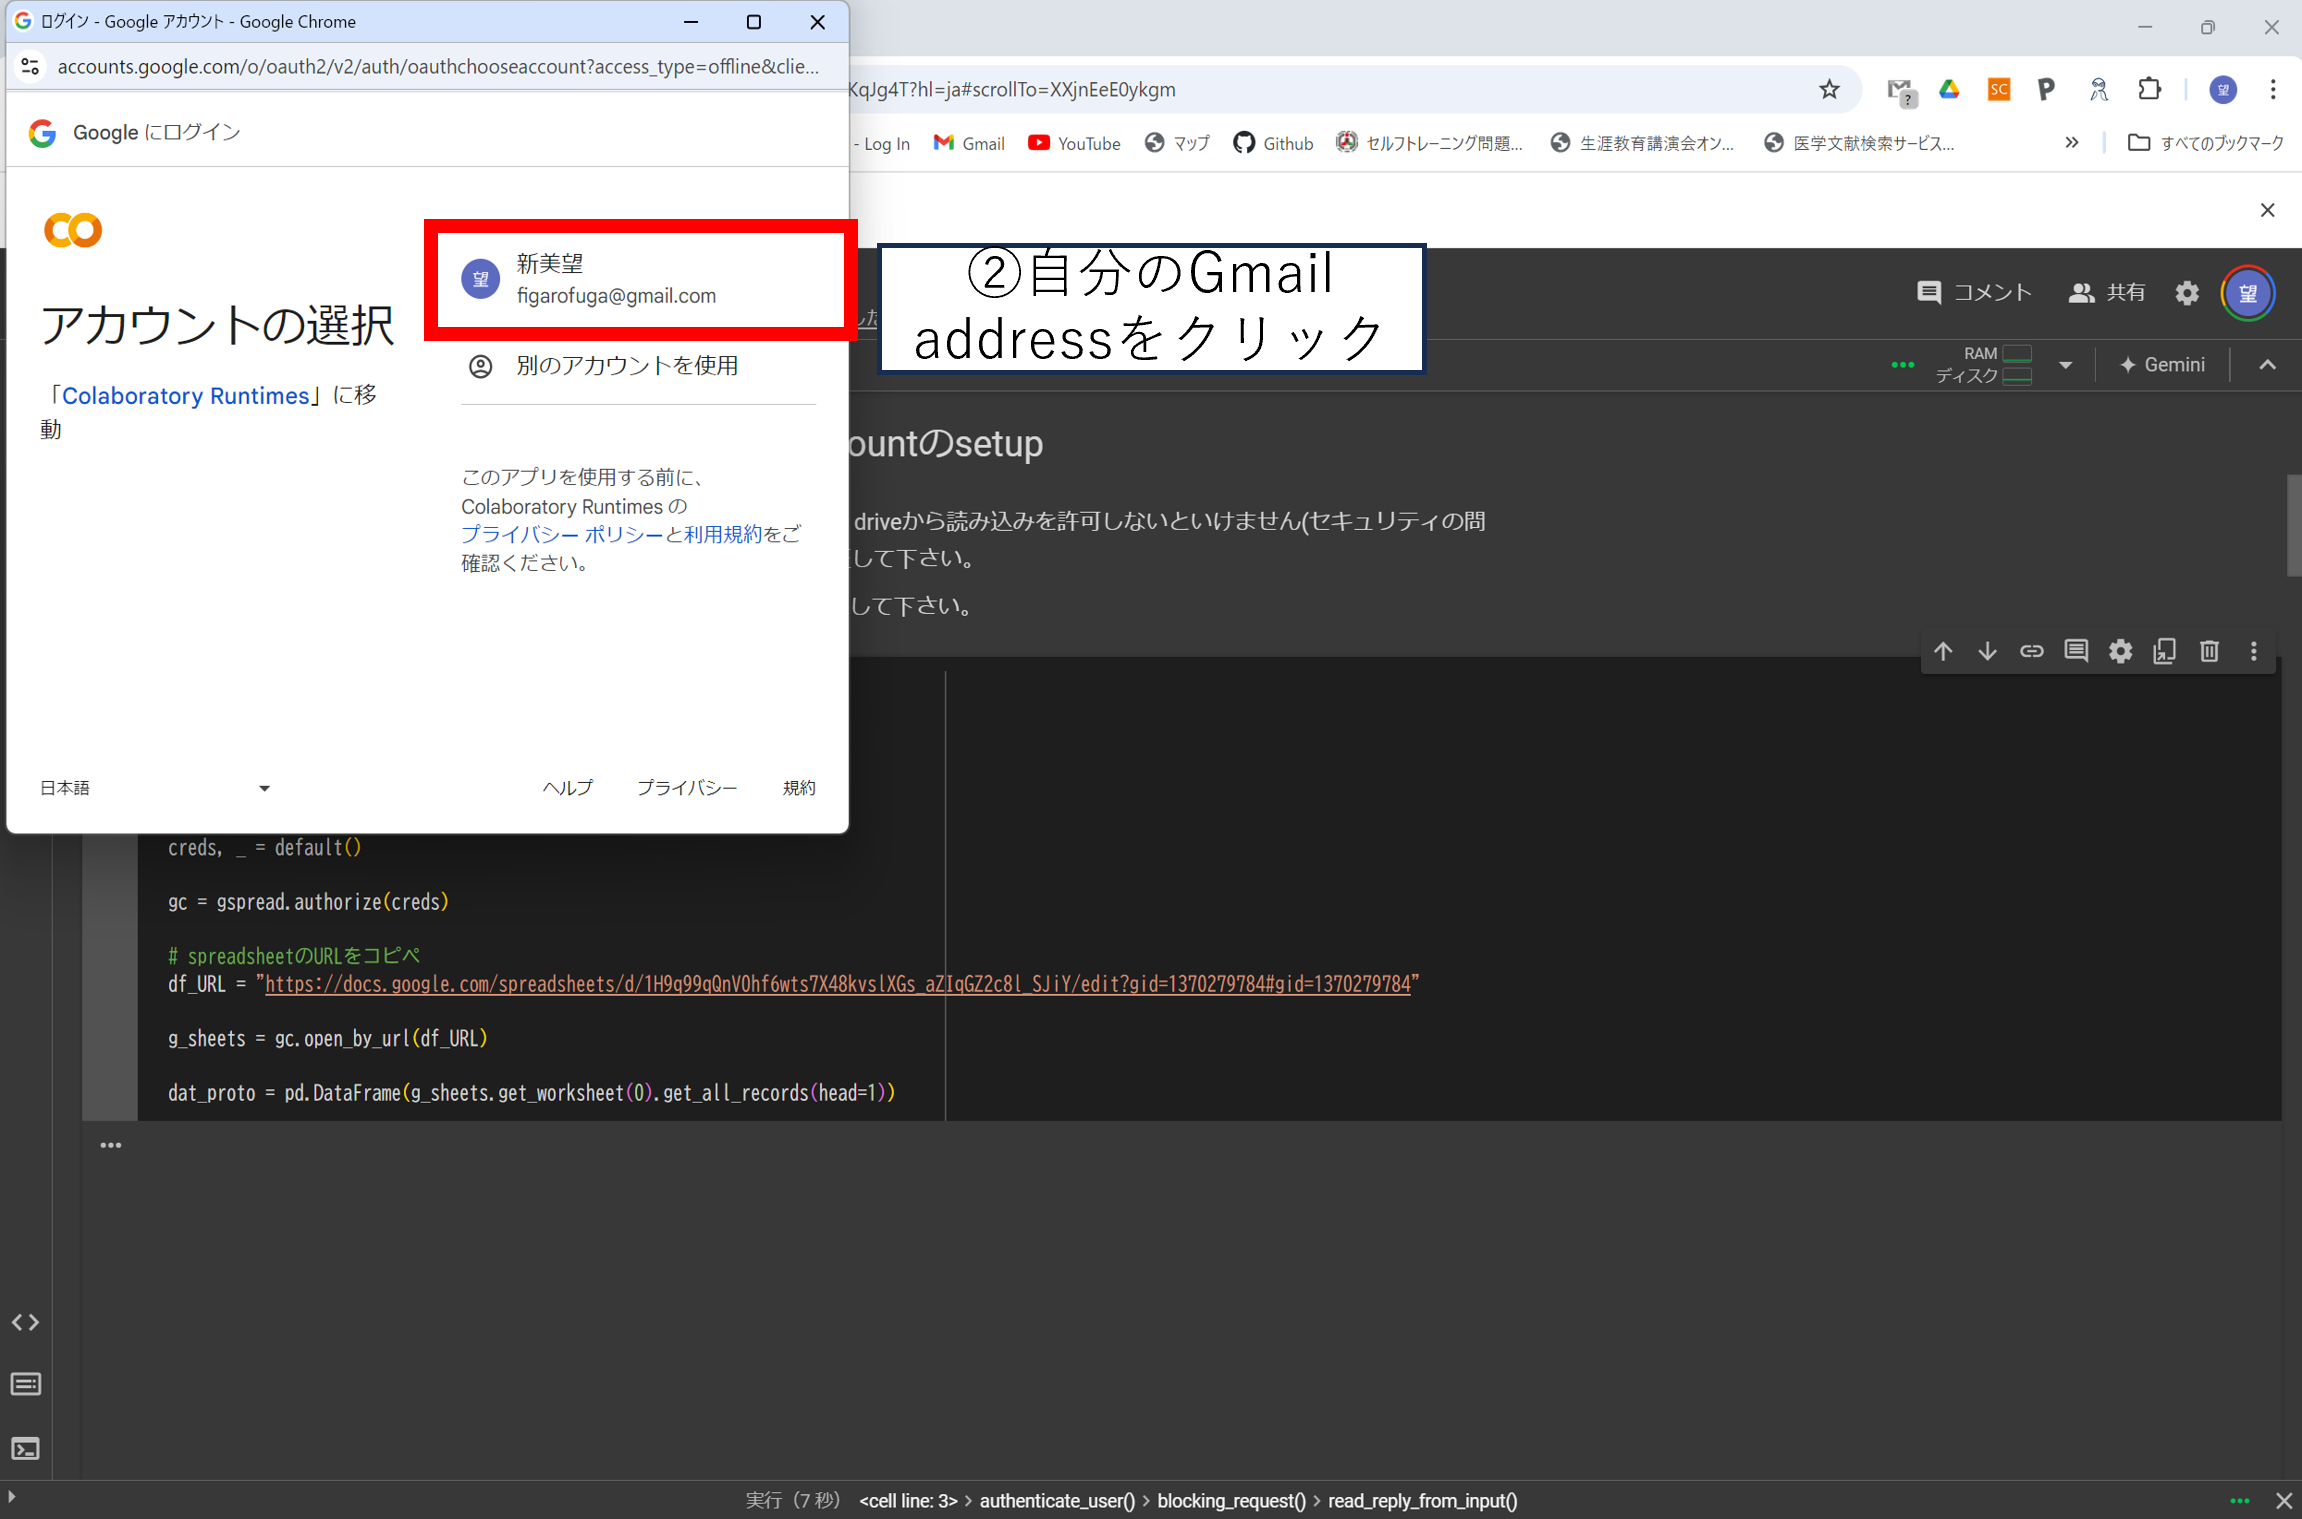

In [ ]:
import pandas as pd
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# 上で記載したURLをそのまま使用
df_URL = df_URL

g_sheets = gc.open_by_url(df_URL)

dat_proto = pd.DataFrame(g_sheets.get_worksheet(0).get_all_records(head=1))

In [ ]:
import re
import pandas as pd


# データの読み込みと前処理
dat = (dat_proto
       .assign(name=lambda x: x['お名前'].str.replace('[　 ]', '', regex=True))
       .assign(doctoryear=lambda x: x['あなたは医師何年目ですか？'].replace(r'年.*', '', regex=True).astype(int))
       .rename(columns={'C日直以外の日・当直の該当者ですか？': 'tochoku_yn',
                        'あなたの専門は何ですか？': 'specialty'})
)

def extract_date(column_name):
    match = re.search(r'\d+月\d+日', column_name)
    if match:
        return match.group()  # 日付部分のみを返す
    return column_name  # マッチしない場合は元の列名を返す

dat_tochoku = (dat
        .sort_values(by='doctoryear')
        .query('tochoku_yn == "はい"')
        .filter(regex=r'名前|doctoryear|specialty|タイムスタンプ|立場|日直・当直希望.*\d{1,2}月')
        # 同一人物が複数回投稿した場合に一番時間が最後の投稿を採用
        .assign(タイムスタンプ=lambda x: pd.to_datetime(x['タイムスタンプ']))
        .sort_values(by='タイムスタンプ', ascending=True)
        .groupby('お名前')
        .last()
        .drop(['タイムスタンプ'], axis=1)
        .reset_index()
        .rename(columns={'お名前': 'name',
                         'あなたの立場は？': 'position'})
        # 表記揺れを防ぐために姓名の間の全角、半角問わずスペースを除去
        .assign(name=lambda x: x['name'].str.replace('[　 ]', '', regex=True))
        .rename(columns=lambda x: extract_date(x))
)

days_in_month = dat_tochoku.filter(regex=r'\d月\d{1,2}日').shape[1]


In [ ]:
# ベースラインのdictionaryを作るための関数です。

def create_availability_dict(df):
    result = {}

    # 1または2桁の数字にマッチするパターンを設定
    date_pattern = re.compile(r"(\d{1,2})月(\d+)日")

    for index, row in df.iterrows():
        name = row["name"]
        availability = {"希望日": [], "不可日": []}

        for col in df.columns:
            match = date_pattern.match(col)
            if match:
                month = match.group(1)  # 月を抽出
                day = int(match.group(2))  # 日を抽出

                if row[col] == "希望日":
                    availability["希望日"].append(day)
                elif row[col] == "不可日":
                    availability["不可日"].append(day)

        availability["希望日"] = [day - 1 for day in availability["希望日"]]
        availability["不可日"] = [day - 1 for day in availability["不可日"]]
        result[name] = availability

    return result
# ベースとなるdictionaryを作成
availability_dict = create_availability_dict(dat_tochoku)


# 担当者の確認と割り当てるスタッフ、レジデントの決定

ここが一番面倒です。
Google formに記載しない人がいますし、レジデントは毎月担当者が変わります(外病院、循環器や救急ローテートなど)。
また、ER担当などすでに決まっている(あるいは手で決めたほうが楽)場合もあります。
そのため、入力した人を全部機械的に決めるのは無理があります。


1.   事前に手動で決める(ERローテータ、腎内 門松先生など)人を決めて、その人はこの機械的に決めるスクリプトから外します。当直係自身の予定も入れちゃうのが良いと思います。
2.   残りの人を機械的に決めましょう。

手持ちの"当直一次救急実績"ファイルなどを見て、当直を担当する医師と以下のアウトプットを目で確認してください。以下にあるリスト作成などは新字体・旧字体含めて一致しないとエラーが出ます。セルのアウトプットの結果の一部のコピー&ペーストする事を推奨します。

In [ ]:
import pprint

# 年次順に名前を並べています。ただし11年目以上は全部一緒です
answered_staffs = dat_tochoku.query('position == "スタッフ"').sort_values(by=['specialty', 'doctoryear'])['name'].unique().tolist()

# 年次順に名前を並べています。ただし11年目以上は全部一緒です
answered_residents = dat_tochoku.query('position == "レジデント/フェロー"').sort_values(by=['specialty', 'doctoryear'])['name'].unique().tolist()


print("Google formに答えたレジデント \n")
pprint.pp(answered_residents, width = 50, compact = True)
print("\nGoogle formに答えたスタッフ \n")
pprint.pp(answered_staffs, width = 50, compact = True)

Google formに答えたレジデント 

['石井真央', '福井梓穂', '吉田博道', '熊木聡美', '佐川偲', '先崎光',
 '吉村梨沙', '岡村真伊', '鈴木徹志郎', '黒崎颯', '山本晴二郎', '荒金直美',
 '東條誠也', '勝俣敬寛', '小宮健太郎', '谷岡友則', '野上創生', '高梨航輔',
 '髙木菜々美', '中枝建郎', '佐久川佳怜', '川島瞬', '松原龍輔', '宗大輔',
 '松井貴裕', '仲田太郎', '岩﨑文美', '莇舜平', '星貴文', '平井智大']

Google formに答えたスタッフ 

['持丸貴生', '篠﨑太郎', '津山頌章', '青木康浩', '松永崇宏', '福原誠一郎',
 '脇坂悠介', '茅島敦人', '吉田心慈', '新美望', '林智史', '久冨木原健二',
 '雪野満', '門松賢', '大重達寛', '川瀬咲']


In [65]:
#@markdown * Google formを書かなかったスタッフの名前を記載して下さい。["新美望", "林智史"]などのようにpython list形式で書いて下さい。姓名の間にスペースは入れないほうが安全です。誰もいない時は`[]`とだけ入れてください。
no_answered_staffs = [] # @param {"type":"raw"}


total_staffs = (answered_staffs + no_answered_staffs)


#@markdown * Google formを書かなかったレジデント/フェローの名前を記載して下さい。["新美望", "林智史"]などのようにpython list形式で書いて下さい。誰もいない時は`[]`とだけ入れてください。
no_answered_residents = ['花岡孝行']# @param {"type":"raw"}


total_residents = (answered_residents + no_answered_residents)

total_members = (total_staffs + total_residents)

import pprint

print("\n当直担当の全メンバー \n")
pprint.pp(total_members, width = 50, compact = True)



当直担当の全メンバー 

['持丸貴生', '篠﨑太郎', '津山頌章', '青木康浩', '松永崇宏', '福原誠一郎',
 '脇坂悠介', '茅島敦人', '吉田心慈', '新美望', '林智史', '久冨木原健二',
 '雪野満', '門松賢', '大重達寛', '川瀬咲', '石井真央', '福井梓穂',
 '吉田博道', '熊木聡美', '佐川偲', '先崎光', '吉村梨沙', '岡村真伊',
 '鈴木徹志郎', '黒崎颯', '山本晴二郎', '荒金直美', '東條誠也', '勝俣敬寛',
 '小宮健太郎', '谷岡友則', '野上創生', '高梨航輔', '髙木菜々美', '中枝建郎',
 '佐久川佳怜', '川島瞬', '松原龍輔', '宗大輔', '松井貴裕', '仲田太郎',
 '岩﨑文美', '莇舜平', '星貴文', '平井智大', '花岡孝行']


In [67]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import math


# チェックボックスを作成する関数
def create_checkboxes():
    checkboxes = []
    for letter in total_members:
        checkboxes.append(widgets.Checkbox(value=False, description=letter))
    return checkboxes

# 整列するためのヘルパー関数
def create_grid(checkboxes, n_columns=4):
    rows = math.ceil(len(checkboxes) / n_columns)
    grid = []
    for i in range(rows):
        grid.append(widgets.HBox(checkboxes[i * n_columns:(i + 1) * n_columns]))
    return widgets.VBox(grid)

# 「Make list」ボタンを押したときにチェックボックスを表示する関数
def on_make_list_button_click(b):
    clear_output()  # 既存のUIをクリア
    checkboxes = create_checkboxes()  # チェックボックスを生成
    display(create_grid(checkboxes))  # チェックボックスを4列に整列して表示
    display(submit_button)  # 提出ボタンを表示

    # チェックされた項目をリストにして表示する関数
    def on_submit_button_click(s):
        selected_items = [checkbox.description for checkbox in checkboxes if checkbox.value]
        clear_output()  # チェックボックスとボタンをクリア
        display(widgets.HTML(f"<b>Selected List:</b> {selected_items}"))  # 選択されたリストを表示
        display(make_list_button)  # 「Make list」ボタンを再表示

    # ボタンが複数回クリックされても関数が複数回登録されないように一度だけ設定
    submit_button.on_click(on_submit_button_click)

# 「Make list」ボタンを作成
make_list_button = widgets.Button(description="選択")
make_list_button.on_click(on_make_list_button_click)

# 提出ボタンを作成
submit_button = widgets.Button(description="リスト作成")

# 最初に「Make list」ボタンを表示
display(make_list_button)

HTML(value="<b>Selected List:</b> ['雪野満', '石井真央']")

Button(description='選択', style=ButtonStyle())

In [69]:
#@markdown * Google formに記載があるが、何らかの理由で事前に割り当てるスタッフの名前を記載下さい(ご自身でも大丈夫です)。["門松賢", "林智史"]などのようにカンマ区切りで書いて下さい。ここは、上のセルのアウトプットの名前と完全に一致しないといけません。誰もいない時は`[]`とだけ入れてください。
remove_staffs = ['門松賢', '川瀬咲', '雪野満', '久冨木原健二']# @param {"type":"raw"}

staffs = list(filter(lambda x: x not in remove_staffs, total_staffs))

#@markdown * Google formに記載があるが、何らかの理由で事前に割り当てるレジデント/フェローを記載下さい(ER担当のレジデントなど)。["新美望", "太良史郎"]などのようにカンマ区切りで書いて下さい。上のセルのアウトプットの名前と完全に一致しないといけません。誰もいない時は`[]`とだけ入れてください。
remove_residents = ['岡村真伊', '黒崎颯', '先崎光', '莇舜平']# @param {"type":"raw"}


#@markdown * 事前に当直回数を1回に限定するメンバーのリストです。["新美望", "太良史郎"]などのようにカンマ区切りで書いて下さい。使いすぎると結果が収束しないので適宜調整してください。なお、remove_staffs/remove_residentsのメンバーは入れないでください。ここは、上のセルのアウトプットの名前と完全に一致しないといけません。誰もいない時は`[]`とだけ入れてください。
members_1times = []# @param {"type":"raw"}

#@markdown * 事前に当直回数を2回に限定するメンバーのリストです。["新美望", "太良史郎"]などのようにカンマ区切りで書いて下さい。使いすぎると結果が収束しないので適宜調整してください。なお、remove_staffs/remove_residentsのメンバーは入れないでください。ここは、上のセルのアウトプットの名前と完全に一致しないといけません。誰もいない時は`[]`とだけ入れてください。
members_2times = []# @param {"type":"raw"}

#@markdown * 事前に当直回数を3回に限定するメンバーのリストです。["新美望", "太良史郎"]などのようにカンマ区切りで書いて下さい。使いすぎると結果が収束しないので適宜調整してください。なお、remove_staffs/remove_residentsのメンバーは入れないでください。ここは、上のセルのアウトプットの名前と完全に一致しないといけません。誰もいない時は`[]`とだけ入れてください。
members_3times = []# @param {"type":"raw"}

#@markdown * 事前に当直回数を少なめにするメンバーのリストです(上と違い、具体的な回数制限はありません)。["新美望", "太良史郎"]などのようにカンマ区切りで書いて下さい。使いすぎると結果が収束しないので適宜調整してください。また、上の回数を具体的に決める変数とは併用しないでください。なお、remove_staffs/remove_residentsのメンバーは入れないでください。ここは、上のセルのアウトプットの名前と完全に一致しないといけません。誰もいない時は`[]`とだけ入れてください。
min_members = ['新美望','熊木聡美']# @param {"type":"raw"}


residents = list(filter(lambda x: x not in remove_residents, total_residents))


all_members = (staffs + residents)

import pprint

print("\nプログラムを使って割当てを決めるレジデント \n")
pprint.pp(residents, width = 50, compact = True)
print("\nプログラムを使って割当てを決めるスタッフ \n")
pprint.pp(staffs, width = 50, compact = True)
print("\nプログラムを使って割当てを決める全メンバー \n")
pprint.pp(all_members, width = 50, compact = True)



今回、プログラムを使って割当てを決めるレジデント 

['石井真央', '福井梓穂', '吉田博道', '熊木聡美', '佐川偲', '吉村梨沙',
 '鈴木徹志郎', '山本晴二郎', '荒金直美', '東條誠也', '勝俣敬寛',
 '小宮健太郎', '谷岡友則', '野上創生', '高梨航輔', '髙木菜々美', '中枝建郎',
 '佐久川佳怜', '川島瞬', '松原龍輔', '宗大輔', '松井貴裕', '仲田太郎',
 '岩﨑文美', '星貴文', '平井智大', '花岡孝行']

今回、プログラムを使って割当てを決めるスタッフ 

['持丸貴生', '篠﨑太郎', '津山頌章', '青木康浩', '松永崇宏', '福原誠一郎',
 '脇坂悠介', '茅島敦人', '吉田心慈', '新美望', '林智史', '大重達寛']

今回、プログラムを使って割当てを決める全メンバー 

['持丸貴生', '篠﨑太郎', '津山頌章', '青木康浩', '松永崇宏', '福原誠一郎',
 '脇坂悠介', '茅島敦人', '吉田心慈', '新美望', '林智史', '大重達寛',
 '石井真央', '福井梓穂', '吉田博道', '熊木聡美', '佐川偲', '吉村梨沙',
 '鈴木徹志郎', '山本晴二郎', '荒金直美', '東條誠也', '勝俣敬寛',
 '小宮健太郎', '谷岡友則', '野上創生', '高梨航輔', '髙木菜々美', '中枝建郎',
 '佐久川佳怜', '川島瞬', '松原龍輔', '宗大輔', '松井貴裕', '仲田太郎',
 '岩﨑文美', '星貴文', '平井智大', '花岡孝行']


## 先月の月末担当者の調整

以下のセルで先月月末の当直者が今月の月初に当直をしないように調整します。
試しに6日前までを手入力にしています。もしも、インターバルを4日まで可にしている場合はlast_day5_workerとlast_day6_workerを`[]`にすればよいです。以下にCopy and paste用にtotal_membersも念の為に出しておきます。

In [70]:
import pprint

print("\n当直担当の全メンバー \n")
pprint.pp(total_members, width = 50, compact = True)

import ipywidgets as widgets
from IPython.display import display, clear_output
import math


# チェックボックスを作成する関数
def create_checkboxes():
    checkboxes = []
    for letter in total_members:
        checkboxes.append(widgets.Checkbox(value=False, description=letter))
    return checkboxes

# 整列するためのヘルパー関数
def create_grid(checkboxes, n_columns=4):
    rows = math.ceil(len(checkboxes) / n_columns)
    grid = []
    for i in range(rows):
        grid.append(widgets.HBox(checkboxes[i * n_columns:(i + 1) * n_columns]))
    return widgets.VBox(grid)

# 「Make list」ボタンを押したときにチェックボックスを表示する関数
def on_make_list_button_click(b):
    clear_output()  # 既存のUIをクリア
    checkboxes = create_checkboxes()  # チェックボックスを生成
    display(create_grid(checkboxes))  # チェックボックスを4列に整列して表示
    display(submit_button)  # 提出ボタンを表示

    # チェックされた項目をリストにして表示する関数
    def on_submit_button_click(s):
        selected_items = [checkbox.description for checkbox in checkboxes if checkbox.value]
        clear_output()  # チェックボックスとボタンをクリア
        display(widgets.HTML(f"<b>Selected List:</b> {selected_items}"))  # 選択されたリストを表示
        display(make_list_button)  # 「Make list」ボタンを再表示

    # ボタンが複数回クリックされても関数が複数回登録されないように一度だけ設定
    submit_button.on_click(on_submit_button_click)

# 「Make list」ボタンを作成
make_list_button = widgets.Button(description="選択")
make_list_button.on_click(on_make_list_button_click)

# 提出ボタンを作成
submit_button = widgets.Button(description="リスト作成")

# 最初に「Make list」ボタンを表示
display(make_list_button)

HTML(value="<b>Selected List:</b> ['福井梓穂', '吉田博道', '小宮健太郎']")

Button(description='選択', style=ButtonStyle())

In [ ]:
#@markdown * 先月の最終日の当直の人を記載してください。例えば、決めたいのが4月の当直とした時に3月31日の人です。["新美望", "太良史郎"]などのようにカンマ区切りで書いて下さい。total_membersの名前と完全に一致しないといけません。
last_day1_worker = ['小宮健太郎', '平井智大', '岩﨑文美']# @param {"type":"raw"}

#@markdown * 先月の最終2日前の当直の人を記載してください。例えば、決めたいのが4月の当直とした時に3月30日の人です。["新美望", "太良史郎"]などのようにカンマ区切りで書いて下さい。total_membersの名前と完全に一致しないといけません。
last_day2_worker = ['篠﨑太郎','莇舜平', '谷岡友則']# @param {"type":"raw"}

#@markdown * 先月の最終3日前の当直の人を記載してください。例えば、決めたいのが4月の当直とした時に3月29日の人です。["新美望", "太良史郎"]などのようにカンマ区切りで書いて下さい。total_membersの名前と完全に一致しないといけません。
last_day3_worker = ['青木康浩', '久富木原健二', '石井真央']# @param {"type":"raw"}

#@markdown * 先月の最終4日前の当直の人を記載してください。例えば、決めたいのが4月の当直とした時に3月28日の人です。["新美望", "太良史郎"]などのようにカンマ区切りで書いて下さい。total_membersの名前と完全に一致しないといけません。
last_day4_worker = ['林智史', '福井梓穂']# @param {"type":"raw"}

#@markdown * 先月の最終5日前の当直の人を記載してください。例えば、決めたいのが4月の当直とした時に3月27日の人です。["新美望", "太良史郎"]などのようにカンマ区切りで書いて下さい。total_membersの名前と完全に一致しないといけません。調整不要の場合は`[]`だけ、記載してください。
last_day5_worker = ['熊木聡美', '吉村梨沙', '大重達寛', '仲田太郎']# @param {"type":"raw"}

#@markdown * 先月の最終6日前の当直の人を記載してください。例えば、決めたいのが4月の当直とした時に3月26日の人です。["新美望", "太良史郎"]などのようにカンマ区切りで書いて下さい。total_membersの名前と完全に一致しないといけません。調整不要の場合は`[]`だけ、記載してください。
last_day6_worker = ['松原龍輔', '津山頌章', '荒金直美']# @param {"type":"raw"}




In [ ]:

# last_workのリストをまとめた辞書（番号とリストを対応付け）
last_work_dict = {
    6: last_day1_worker,
    5: last_day2_worker,
    4: last_day3_worker,
    3: last_day4_worker,
    2: last_day5_worker,
    1: last_day6_worker,
}

# 各last_workリストに対応する日数を不可日に追加
for work_num, person_list in last_work_dict.items():
    # 追加する日数の範囲 (0からwork_num)
    days_to_add = list(range(work_num))

    if person_list:
    # 各人物に対して不可日に追加
      for person in person_list:
          if person in availability_dict:
              # 現在の不可日と新しく追加する日を結合し、重複を排除
              availability_dict[person]['不可日'] = sorted(list(set(availability_dict[person]['不可日'] + days_to_add)))

## 禁止日追加

後で追加で誰かの日付を"不可日"に上書きするためのスクリプトです。
決して必須ではありませんが、各科の調整で必要なこともあります(例えば、血液内科の場合はC日直に血液内科Drが担当の時に他のレジデントやスタッフを入れないでほしいとの要望があります)。
何らかの理由で後で調整が必要な時に使ってください。

一応、Google spreadsheetを手でいじるのが一番早いのですが、元データにてを加えるとなにかあった時に修正不可能になるのでこのスクリプトを追加しました。

python dictionaryの形式です。keyの名前はtotal_membersの名前と完全に一致させてください。valueはリストの日付です。
具体的には、

`{'名前1': [追加する日付1, 追加する日付1, ...], '名前2': [追加する日付1, 追加する日付1, ...], ...}`

の形式で書いてください。
追加する日付は、たとえ1日だけでも`[]`で囲ってください。

Ex) 新美が1日、林智史が3日、4日、5日、太良史郎が2日、4日、6日、8日を新たに不可日にしたい時は

{'新美望': [1], '林智史': [3, 4, 5], '太良史郎: [2, 4, 6, 8]'}
と記載してください

繰り返しになりますが、上記のtotal_membersと完全に一致させる必要があります。以下のアウトプットをCopy and pasteが良いと思います。

['11月1日(金)',
 '11月2日(土)',
 '11月3日(日)',
 '11月4日(祝)',
 '11月5日(火)',
 '11月6日(水)',
 '11月7日(木)',
 '11月8日(金)',
 '11月9日(土)',
 '11月10日(日)',
 '11月11日(月)',
 '11月12日(火)',
 '11月13日(水)',
 '11月14日(木)',
 '11月15日(金)',
 '11月16日(土)',
 '11月17日(日)',
 '11月18日(月)',
 '11月19日(火)',
 '11月20日(水)',
 '11月21日(木)',
 '11月22日(金)',
 '11月23日(土)',
 '11月24日(日)',
 '11月25日(月)',
 '11月26日(火)',
 '11月27日(水)',
 '11月28日(木)',
 '11月29日(金)',
 '11月30日(土)']

In [78]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import math
import pprint

print("\n当直担当の全メンバー \n")
pprint.pp(total_members, width = 50, compact = True)

# 日付リストの作成（仮定としてdatはDataFrame）
day_list = (
    dat
    .filter(regex=r'日直・当直希望.*\d{1,2}月')
    .rename(columns=lambda x: re.search(r'\[(.*?)\]', x).group(1) if re.search(r'\[(.*?)\]', x) else x)
    .columns.to_list()
)

# 4列に整列するためのヘルパー関数
def create_grid(items, n_columns=4):
    rows = math.ceil(len(items) / n_columns)
    grid = []
    for i in range(rows):
        grid.append(widgets.HBox(items[i * n_columns:(i + 1) * n_columns]))
    return widgets.VBox(grid)

# Keyを選択するチェックボックスを作成する関数
def create_key_checkboxes():
    checkboxes = [widgets.Checkbox(value=False, description=key) for key in total_members]
    return checkboxes

# 特定のKeyに対してValue（日付リスト）を選択するチェックボックスを作成する関数
def create_value_checkboxes(key):
    value_checkboxes = [widgets.Checkbox(value=False, description=value) for value in day_list]
    return value_checkboxes

# 「Make dictionary」ボタンを押したときにKeyのチェックボックスを表示
def on_make_dict_button_click(b):
    clear_output()  # 既存のUIをクリア
    key_checkboxes = create_key_checkboxes()  # Keyのチェックボックスを作成
    display(create_grid(key_checkboxes))  # 4列に整列してKeyを表示
    display(next_button)  # 次のステップに進むボタンを表示

    # 「Next」ボタンを押したときに、選択されたKeyの候補に対してValueのチェックボックスを表示
    def on_next_button_click(s):
        clear_output()
        selected_keys = [checkbox.description for checkbox in key_checkboxes if checkbox.value]
        if not selected_keys:
            display(widgets.HTML("<b>No keys selected. Please select at least one key.</b>"))
            display(create_grid(key_checkboxes))
            display(next_button)
            return

        # 選択されたKeyごとにValueのチェックボックスを表示
        value_checkboxes_dict = {}
        for key in selected_keys:
            value_checkboxes_dict[key] = create_value_checkboxes(key)

        display(widgets.HTML("<b>Select values for each key:</b>"))
        for key, value_checkboxes in value_checkboxes_dict.items():
            display(widgets.HTML(f"<b>{key}</b>"))
            display(create_grid(value_checkboxes))  # Valueのチェックボックスを4列に整列

        display(submit_button)  # 辞書作成のためのSubmitボタンを表示

        # Submitボタンを押したら、選択されたKeyとValueの辞書を作成
        def on_submit_button_click(t):
            result_dict = {}
            for key, checkboxes in value_checkboxes_dict.items():
                # 選択された値をそのリスト内のインデックスに変換して辞書に格納
                selected_indices = [day_list.index(cb.description) + 1 for cb in checkboxes if cb.value]
                if selected_indices:
                    result_dict[key] = selected_indices
            clear_output()
            display(widgets.HTML(f"<b>Created Dictionary:</b> {result_dict}"))  # 辞書を表示
            display(make_dict_button)  # 「Make dictionary」ボタンを再表示

        submit_button.on_click(on_submit_button_click)

    next_button.on_click(on_next_button_click)

# 「Make dictionary」ボタンを作成
make_dict_button = widgets.Button(description="dictionary作成")
make_dict_button.on_click(on_make_dict_button_click)

# 「Next」ボタンと「Submit」ボタンを作成
next_button = widgets.Button(description="Next")
submit_button = widgets.Button(description="dictionary表示")

# 最初に「Make dictionary」ボタンを表示
display(make_dict_button)

HTML(value="<b>Created Dictionary:</b> {'雪野満': [30]}")

Button(description='dictionary作成', style=ButtonStyle())

In [75]:
#@markdown * python dictionaryの形式です。keyの名前はtotal_membersの名前と完全に一致させてください。誰も追加しない時も空のDictionaryにしてください(=`{}`だけ)。{'新美望': [1], '林智史': [3, 4, 5]}のように書いてください。
updated_dict = {} # @param {"type":"raw"}

# 日付をindexに変更するために、全てのvalueから1を引く処理
for key, value_list in updated_dict.items():
    # 各リストの要素に1を引く
    updated_dict[key] = [x - 1 for x in value_list]


In [ ]:
# updated_dictの内容をavailability_dictの"不可日"に追加
for emp, unavailable_days in updated_dict.items():
    if emp in availability_dict:
        # "不可日"リストが存在する場合、リストに追加
        availability_dict[emp]['不可日'] += unavailable_days
        # 重複を避けるためにセットにしてからリストに戻す
        availability_dict[emp]['不可日'] = sorted(set(availability_dict[emp]['不可日']))
    else:
        # 名前が存在しない場合はエラーを出す
        raise KeyError(f"{emp} は availability_dict に存在しません。")

In [ ]:
import ipywidgets as widgets
from IPython.display import display

availability_summary = []

for emp in total_members:
    希望日 = availability_dict.get(emp, {}).get('希望日', [])
    不可日 = availability_dict.get(emp, {}).get('不可日', [])
    availability_summary.append({'名前': emp, '希望日': 希望日, '不可日': 不可日})

availability_summary_df = pd.DataFrame(availability_summary)# index が 0スタートのため日付に直すために+1する
availability_summary_df['希望日'] = availability_summary_df['希望日'].apply(lambda x: [i + 1 for i in x])
availability_summary_df['不可日'] = availability_summary_df['不可日'].apply(lambda x: [i + 1 for i in x])

# リストを "3日, 4日, 5日" のような文字列に変換
availability_summary_df['希望日'] = availability_summary_df['希望日'].apply(lambda x: ', '.join([f'{i}日' for i in x]))
availability_summary_df['不可日'] = availability_summary_df['不可日'].apply(lambda x: ', '.join([f'{i}日' for i in x]))

# データフレームをHTMLで表示し、インデックスを非表示にする
html = availability_summary_df.to_html(index=False, escape=False)

# スタイルを追加して名前列の幅を短くし、折り返しを可能にする
style = """
<style>
    table {width: 100%; border-collapse: collapse;}
    th, td {border: 1px solid black; padding: 10px; text-align: center;}
    td {word-wrap: break-word; white-space: pre-wrap;}
    th:first-child, td:first-child {width: 100px;} /* 名前列の横幅を調整 */
</style>
"""

# 表を表示
display(HTML(style + html))

名前,希望日,不可日
持丸貴生,"9日, 16日","1日, 3日, 4日, 5日, 6日, 8日, 10日, 11日, 12日, 13日, 15日, 17日, 18日, 19日, 20日, 22日, 23日, 24日, 25日, 26日, 27日, 29日"
篠﨑太郎,,"1日, 2日, 3日, 4日, 5日, 7日, 10日, 12日, 17日, 19日, 22日, 23日, 24日, 25日, 26日, 27日, 28日, 29日, 30日"
津山頌章,"1日, 2日, 3日, 4日, 7日, 9日, 10日, 14日, 15日, 16日, 17日, 18日, 21日, 23日, 24日, 25日, 28日, 30日","1日, 5日, 6日, 8日, 12日, 13日, 19日, 20日, 22日, 26日, 27日, 29日"
青木康浩,"5日, 12日","1日, 2日, 3日, 4日, 6日, 13日, 20日, 21日, 22日, 23日, 24日, 25日, 27日, 29日, 30日"
松永崇宏,,"1日, 2日, 3日, 4日, 5日, 6日, 7日, 8日, 9日, 10日, 13日, 14日, 15日, 17日, 20日, 21日, 23日, 24日, 27日, 28日"
福原誠一郎,"6日, 20日, 22日, 23日, 27日, 28日, 29日","1日, 2日, 3日, 4日, 5日, 7日, 8日, 9日, 11日, 12日, 13日, 14日, 15日, 16日, 17日, 18日, 19日, 21日, 24日, 25日, 26日, 30日"
脇坂悠介,,"1日, 2日, 7日, 9日, 10日, 14日, 15日, 16日, 17日, 21日, 22日, 23日, 24日, 28日, 29日, 30日"
茅島敦人,"6日, 13日, 27日","1日, 2日, 3日, 4日, 10日, 15日, 16日, 17日, 20日, 21日, 22日, 23日, 24日, 25日"
吉田心慈,,"1日, 2日, 6日, 9日, 10日, 13日, 15日, 19日, 20日, 23日, 24日, 27日, 30日"
新美望,"1日, 2日, 5日, 8日, 9日, 12日, 15日, 16日, 19日, 22日, 23日, 26日, 29日, 30日","4日, 6日, 7日, 10日, 11日, 13日, 14日, 17日, 18日, 20日, 21日, 24日, 25日, 27日, 28日"


# 日毎の割当人数の決定

ここが**最も重要なところです**。

日付と、レジデント、スタッフ、全体の必要人数を記載した`schedule_df`を作って下さい。 平日は3人(内科 1/2, F当直)、土日は4人(内科 1/2, 内科 E/Fです)がデフォルト値です。一番最初に決めた変数で初期値を変更させる事ができます。
将来当直体制が変わったら適宜変化させてください。

+ 平日はresidents_needが1(内科2)、staffs_needが1(内科1)、で内科Fは両方ありなのでall_member_needが3です。
+ 土日はresidents_needが2(内科 E/F)、staffs_needが1(内科 1)、で内科2は両方ありなのでall_member_needが4にしました。

内科1/2や内科E/Fのみならず、土曜日はもともとER担当を入れたり、先生によって事前に決める事もあります(門松先生や神経内科スタッフ/フェローが平日は平日の内科1を2回のみなど)。そのため、以下のschedule_dfでやりたいように割り当てて下さい。
また、年末年始やGWなどでD当直が出た時には逆に増やしてください。

Dropdownで変更した後に

<font face="Serif" size=5 color='red'> **"Update Dataframe"ボタンを押す事を忘れない** <font>

ようにしてください。ここでエラーが出るのが多いですが。大体"Update Dataframe"ボタンを押していないことが原因です。

In [ ]:
import ipywidgets as widgets
import pandas as pd
from IPython.display import display
import re

# 日付リストの作成（仮定としてdatはDataFrame）
day_list = (
    dat
    .filter(regex=r'日直・当直希望.*\d{1,2}月')
    .rename(columns=lambda x: re.search(r'\[(.*?)\]', x).group(1) if re.search(r'\[(.*?)\]', x) else x)
    .columns.to_list()
)

# 初期データフレーム作成
df_initial = (
    pd.DataFrame({'Day': day_list})
    .assign(residents_need=lambda df: df['Day'].str.contains(r'\(土\)|\(日\)|\(祝\)').map({True: residents_need_weekend, False: residents_need_weekday}))
    .assign(staffs_need=lambda df: df['Day'].str.contains(r'\(土\)|\(日\)|\(祝\)').map({True: staffs_need_weekend, False: staffs_need_weekday}))
    .assign(all_member_need=lambda df: df['Day'].str.contains(r'\(土\)|\(日\)|\(祝\)').map({True: all_member_need_weekend, False: all_member_need_weekday}))
)

# 各セルに0〜5の選択肢を持つドロップダウンウィジェットを定義
options = [0, 1, 2, 3, 4, 5]

# ID列として固定表示するためのリスト
ids = df_initial['Day']

# ヘッダーリスト
headers = ['residents_need', 'staffs_need', 'all_member_need']

# レイアウト設定
cell_layout = widgets.Layout(width='200px', margin='0px 5px', text_align='center')
header_layout = widgets.Layout(width='200px', margin='0px 5px', text_align='center')

# ドロップダウンウィジェット作成を関数化
def create_dropdowns(row_idx, row_values):
    return [widgets.Dropdown(options=options, value=row_values[col], layout=cell_layout) for col in headers]

# 新しいデータフレームの各セルに対応するドロップダウンウィジェットを作成
rows = []

# ヘッダー行を作成
header_row = [widgets.HTML(value='<b>Day</b>', layout=header_layout)] + \
             [widgets.HTML(value=f'<b>{header}</b>', layout=header_layout) for header in headers]
rows.append(widgets.HBox(header_row))

# 各行のID列とドロップダウンウィジェットを作成
for idx, row_values in df_initial.iterrows():
    row = [widgets.Label(value=ids[idx], layout=cell_layout)] + create_dropdowns(idx, row_values)
    rows.append(widgets.HBox(row))

# テーブル風に配置
table = widgets.VBox(rows)

# ボタンのレイアウトを調整
button = widgets.Button(description="Update DataFrame", layout=widgets.Layout(width='500px', margin='10px 0px'))

# 表示
display(table)
display(button)

# schedule_df に初期データを保存
schedule_df = df_initial.copy()

# ボタンを作成して、DataFrameに変換する
def on_button_click(b):
    data = []
    is_changed = False  # 変更があったかどうかを記録するフラグ

    # 各行の値を取得
    for idx, row in enumerate(rows[1:]):  # rows[1:]でヘッダー行をスキップ
        row_data = [ids[idx]] + [widget.value for widget in row.children[1:]]  # children[1:]でID列をスキップ
        data.append(row_data)

        # 変更があるかを確認
        if not all(df_initial.loc[idx, col] == row_data[i+1] for i, col in enumerate(headers)):
            is_changed = True

    # 変更があった場合にDataFrameを更新
    if is_changed:
        global schedule_df
        schedule_df = pd.DataFrame(data, columns=['Day'] + headers)
        print("Updated DataFrame:")
        print(schedule_df)
    else:
        print("No changes detected.")

# ボタンにアクションを登録
button.on_click(on_button_click)

# 初期データを確認
print("Initial DataFrame saved:")
print(schedule_df)


Button(description='Update DataFrame', layout=Layout(margin='10px 0px', width='500px'), style=ButtonStyle())

Initial DataFrame saved:
          Day  residents_need  staffs_need  all_member_need
0    11月1日(金)               1            1                3
1    11月2日(土)               2            1                4
2    11月3日(日)               2            1                4
3    11月4日(祝)               2            1                4
4    11月5日(火)               1            1                3
5    11月6日(水)               1            1                3
6    11月7日(木)               1            1                3
7    11月8日(金)               1            1                3
8    11月9日(土)               2            1                4
9   11月10日(日)               2            1                4
10  11月11日(月)               1            1                3
11  11月12日(火)               1            1                3
12  11月13日(水)               1            1                3
13  11月14日(木)               1            1                3
14  11月15日(金)               1            1                3
15  11月16日(土)  

In [ ]:
# schedule_dfの中身をチェックしてください。
import pprint
pprint.pprint(schedule_df)

          Day  residents_need  staffs_need  all_member_need
0    11月1日(金)               1            1                3
1    11月2日(土)               2            1                4
2    11月3日(日)               2            1                4
3    11月4日(祝)               2            1                4
4    11月5日(火)               1            1                3
5    11月6日(水)               1            1                3
6    11月7日(木)               1            1                3
7    11月8日(金)               1            1                3
8    11月9日(土)               2            1                4
9   11月10日(日)               2            1                4
10  11月11日(月)               1            1                3
11  11月12日(火)               1            1                3
12  11月13日(水)               1            1                3
13  11月14日(木)               1            1                3
14  11月15日(金)               1            1                3
15  11月16日(土)               2           

In [ ]:
# 実際の日付とともに、日付のindexも作成。
schedule_df2 = schedule_df.reset_index().rename(columns={'index': 'day_index'})

# Validation function for schedule_Df
def validate_schedule_df(df):
    errors = []

    # Check if the number of rows is exactly 31
    if len(df) != days_in_month:
        errors.append(f"エラー: データフレームの行数は{days_in_month}出なければいけませんが, 現在{len(df)}行です.")

    # Check if residents_need + staffs_need <= all_member_need for each row
    for index, row in df.iterrows():
        if row['residents_need'] + row['staffs_need'] > row['all_member_need']:
            errors.append(f"{row['day_index']+1}日の入力でエラー: residents_need + staffs_need ({row['residents_need']} + {row['staffs_need']}) "
                          f"が({row['all_member_need']})より多いです.")

    return errors

# Run the validation
validation_errors = validate_schedule_df(schedule_df2)

# Output the errors if there are any
if validation_errors:
    for error in validation_errors:
        print(error)
else:
    print("問題ありません.")


問題ありません.


# 線形計画法

ここが最も重要なスケジュール決定の為のScriptです。
線形計画法というものを用いて行います。基本的に、よほどの事がない限り何かしらの答えを出してくれます。もしもErrorが出たり'No feasible solution found.'の場合何かしら事前の設定やデータに異常があります。上の前処理を確認して下さい。


In [ ]:
from ortools.linear_solver import pywraplp


# Google OR-Tools の Solver の作成
solver = pywraplp.Solver.CreateSolver('SCIP')

# 祝日のリスト
holidays_list = schedule_df2[schedule_df2['Day'].str.contains(r'\((土|日|祝\))', regex = True)]['day_index'].to_list()

# 変数の定義
x = {}
for emp in all_members:
    for day in range(days_in_month):
        x[(emp, day)] = solver.IntVar(0, 1, f'shift_{emp}_{day}')

# 各担当者のシフト回数をカウントする変数
shift_count = {}
for emp in all_members:
    shift_count[emp] = solver.Sum(x[(emp, day)] for day in range(days_in_month))

# 最小および最大シフト回数の変数
min_shifts = solver.IntVar(0, days_in_month, 'min_shifts')
max_shifts = solver.IntVar(0, days_in_month, 'max_shifts')

# 最小および最大シフト回数の制約
for emp in all_members:
    solver.Add(shift_count[emp] >= min_shifts)
    solver.Add(shift_count[emp] <= max_shifts)


# 特定メンバーの当直回数を1回に制限する制約
for emp in members_1times:
    solver.Add(shift_count[emp] <= 1)

# 特定メンバーの当直回数を2回に制限する制約
for emp in members_2times:
    solver.Add(shift_count[emp] <= 2)

# 特定メンバーの当直回数を3回に制限する制約
for emp in members_3times:
    solver.Add(shift_count[emp] <= 3)

# 特定メンバーに対してシフト回数を少なめに設定する制約
for emp in min_members:
    solver.Add(shift_count[emp] == min_shifts)

# 他のメンバーには通常のmin_shiftsからmax_shiftsの範囲内でシフトを割り当て
for emp in all_members:
    if emp not in min_members:  # 少なめに設定されているメンバーを除外
        solver.Add(shift_count[emp] >= min_shifts)
        solver.Add(shift_count[emp] <= max_shifts)



# 最大シフト回数と最小シフト回数の差がdiff_in_shifts以下
solver.Add(max_shifts - min_shifts <= diff_in_shifts)

# 目的関数: 希望日を満たすと+1, 不可日を満たすと-500に設定
objective = solver.Objective()
for emp in all_members:
    for day in range(days_in_month):
        if day in availability_dict.get(emp, {}).get('希望日', []):
            objective.SetCoefficient(x[(emp, day)], 1)
        if day in availability_dict.get(emp, {}).get('不可日', []):
            objective.SetCoefficient(x[(emp, day)], -500)
objective.SetMaximization()

# schedule_dfを用いた人数の割当
for index, row in schedule_df2.iterrows():
    day = row['day_index']

    # 各日の必要なメンバー数に基づいて制約を追加
    solver.Add(solver.Sum(x[(emp, day)] for emp in all_members) == row['all_member_need'])
    solver.Add(solver.Sum(x[(emp, day)] for emp in staffs) >= row['staffs_need'])
    solver.Add(solver.Sum(x[(emp, day)] for emp in residents) >= row['residents_need'])

# 担当者の間隔制約をinterva_shifts以上にする
for emp in all_members:
    for day in range(days_in_month):
        # 正の方向での間隔制約
        if day >= interval_shifts:
            solver.Add(solver.Sum(x[(emp, d)] for d in range(day - interval_shifts, day)) <= 1)
        # 逆の方向での間隔制約
        if day <= days_in_month - (interval_shifts + 1):
            solver.Add(solver.Sum(x[(emp, d)] for d in range(day + 1, day + (interval_shifts + 1))) <= 1)

# 祝日にシフトを割り当てられる回数をスタッフとレジデントで各々指定
for emp in staffs:
    holiday_shifts = solver.Sum(x[(emp, day)] for day in holidays_list)
    solver.Add(holiday_shifts <= staff_holiday_num)

for emp in residents:
    holiday_shifts = solver.Sum(x[(emp, day)] for day in holidays_list)
    solver.Add(holiday_shifts <= resident_holiday_num)


# 問題を解く
status = solver.Solve()

<ipython-input-56-6604a8c5c7e2>:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  holidays_list = schedule_df2[schedule_df2['Day'].str.contains(r'\((土|日|祝\))', regex = True)]['day_index'].to_list()


In [ ]:
# 結果の表示と保存
from IPython.display import display, HTML, Markdown
# 結果を格納するための空のリストおよびDictionaryを作成
shift_assignments = []
shift_counts = []
penalty_details = []
total_penalty = 0
holiday_assignments = {}


if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
    for day in range(days_in_month):
        assigned = [emp for emp in all_members if x[(emp, day)].solution_value() == 1]
        shift_assignments.append({'Day': schedule_df['Day'][day], 'Assigned': ", ".join(assigned)})

         # ペナルティの計算
        for emp in all_members:
            if x[(emp, day)].solution_value() == 1:
                if day in availability_dict.get(emp, {}).get('不可日', []):
                    penalty_details.append({'Name': emp, 'Day': day + 1, 'Penalty': -500})
                    total_penalty += -500
                elif day in availability_dict.get(emp, {}).get('希望日', []):
                    penalty_details.append({'Name': emp, 'Day': day + 1, 'Penalty': 1})
                    total_penalty += 1

    # 全体のシフト割当のDataframe
    shift_assignments_df = pd.DataFrame(shift_assignments)


    # Penaltyの詳細とDataframe作成
    penalty_details_df = pd.DataFrame(penalty_details)

    for emp in all_members:
        shift_counts.append({'Name': emp, 'Shift Count': shift_count[emp].solution_value()})

    shift_counts_df = pd.DataFrame(shift_counts)

    # 休日に割り当てられた回数のDataFrame
    for emp in all_members:
        holiday_assignments[emp] = sum(x[(emp, day)].solution_value() for day in holidays_list)

    holiday_assignments_df = pd.DataFrame(list(holiday_assignments.items()), columns=['name', 'holiday_count'])

    # ここから、きれいにアウトプットするためのスクリプト

    ## シフト割当のアウトプット

    shift_assignments_dfs = [shift_assignments_df.iloc[i:i+10] for i in range(0, len(shift_assignments_df), 10)]
    # 横に4つ並べて表示するためのHTMLを生成
    html_output_shiftassign = "<table><tr>"
    for sub_df in shift_assignments_dfs:
    # 各データフレームをHTMLに変換し、列として表示
      html_output_shiftassign += "<td style='padding: 10px; vertical-align: top;'>" + sub_df.to_html(index=False) + "</td>"

    html_output_shiftassign += "</tr></table>"

    print("シフトの割当:")
    display(HTML(html_output_shiftassign))

    ## シフト回数のアウトプット

    shift_counts_dfs = [shift_counts_df.iloc[i:i+10] for i in range(0, len(shift_counts_df), 10)]
    # 横に4つ並べて表示するためのHTMLを生成
    html_output_shiftcount = "<table><tr>"
    for sub_df in shift_counts_dfs:
    # 各データフレームをHTMLに変換し、列として表示
      html_output_shiftcount += "<td style='padding: 10px; vertical-align: top;'>" + sub_df.to_html(index=False) + "</td>"

    html_output_shiftcount += "</tr></table>"

    print("\nシフト回数:")
    display(HTML(html_output_shiftcount))

    ## ペナルティのアウトプット

    penalty_details_dfs = [penalty_details_df.iloc[i:i+10] for i in range(0, len(penalty_details_df), 10)]
    # 横に4つ並べて表示するためのHTMLを生成
    html_output_penalty = "<table><tr>"
    for sub_df in penalty_details_dfs:
    # 各データフレームをHTMLに変換し、列として表示
      html_output_penalty += "<td style='padding: 10px; vertical-align: top;'>" + sub_df.to_html(index=False) + "</td>"

    html_output_penalty += "</tr></table>"

    print("\nPenaltyの詳細:希望日に割り当てたら+1, 不可日に割り当てたら-500")
    display(HTML(html_output_penalty))
    print(f"\nTotal Penalty: {total_penalty}")

    ## 休日割当のアウトプット

    holiday_assignments_dfs = [holiday_assignments_df.iloc[i:i+10] for i in range(0, len(holiday_assignments_df), 10)]
    # 横に4つ並べて表示するためのHTMLを生成
    html_output_holiday_assign = "<table><tr>"
    for sub_df in holiday_assignments_dfs:
    # 各データフレームをHTMLに変換し、列として表示
      html_output_holiday_assign += "<td style='padding: 10px; vertical-align: top;'>" + sub_df.to_html(index=False) + "</td>"

    html_output_holiday_assign += "</tr></table>"

    # Markdownとして表示
    print(f"\n土日の担当回数\n")
    display(HTML(html_output_holiday_assign))


else:
    print("No feasible solution found.")

シフトの割当:


Day,Assigned
11月1日(金),"新美望, 中枝建郎, 松井貴裕"
11月2日(土),"津山頌章, 吉田博道, 東條誠也, 花岡孝行"
11月3日(日),"吉田心慈, 山本晴二郎, 川島瞬, 星貴文"
11月4日(祝),"脇坂悠介, 吉村梨沙, 鈴木徹志郎, 仲田太郎"
11月5日(火),"青木康浩, 石井真央, 勝俣敬寛"
11月6日(水),"茅島敦人, 谷岡友則, 佐久川佳怜"
11月7日(木),"津山頌章, 高梨航輔, 髙木菜々美"
11月8日(金),"吉田心慈, 中枝建郎, 川島瞬"
11月9日(土),"持丸貴生, 熊木聡美, 東條誠也, 岩﨑文美"
11月10日(日),"福原誠一郎, 山本晴二郎, 松原龍輔, 花岡孝行"



シフト回数:


Name,Shift Count
持丸貴生,2.0
篠﨑太郎,2.0
津山頌章,3.0
青木康浩,2.0
松永崇宏,3.0
福原誠一郎,3.0
脇坂悠介,3.0
茅島敦人,3.0
吉田心慈,3.0
新美望,2.0



Penaltyの詳細:希望日に割り当てたら+1, 不可日に割り当てたら-500


Name,Day,Penalty
新美望,1,1
津山頌章,2,1
鈴木徹志郎,4,1
青木康浩,5,1
勝俣敬寛,5,1
茅島敦人,6,1
津山頌章,7,1
髙木菜々美,7,1
川島瞬,8,1
持丸貴生,9,1



Total Penalty: 41

土日の担当回数



name,holiday_count
持丸貴生,1.0
篠﨑太郎,1.0
津山頌章,1.0
青木康浩,0.0
松永崇宏,1.0
福原誠一郎,1.0
脇坂悠介,1.0
茅島敦人,0.0
吉田心慈,1.0
新美望,1.0


# 結果の保存とアウトプット

これだけでも目で見ながらできると思います。
一応、結果をダウンロードするスクリプトを書いておきます。
ご自身のPCにダウンロードする方法と、元々のGoogle spreadsheetに新しいタブで追加したするものです。チェックボックスでお好きな方を選んでください。
CSVだと文字化けしたのでExcelにしています。
ご自身の「ダウンロードフォルダ」を確認下さい(Macだと別の名前かもしれません)
2つ目は元々読み込んだGoogle spreadsheetに追加で書き込む方法です。別個のファイルができないのでこちらの方がファイルが取っ散らかなくて良いかもしれません。


In [ ]:
# Placeholder for the "Install to download directory" action
def perform_install_to_download_directory(b):
    # Logic for installation goes here
    # Shift assignmentsをExcel fileとして別個にダウンロードをする方法

  from google.colab import files
  import pandas as pd

# データフレームをExcelファイルとして保存
  excel_file_path = 'shift_assignments.xlsx'
  shift_assignments_df.to_excel(excel_file_path, index=False)

# Excelファイルをダウンロード
  files.download(excel_file_path)

  print("Installing to download directory...")

# Placeholder for the "Push new tab to Google Spreadsheet" action
def perform_push_new_tab_to_google_spreadsheet(b):
    # Logic for pushing a new tab goes here
  # 元々のGoogle spreadsheetにタブを追加してそこに書き込む方法

  import gspread
  from oauth2client.client import GoogleCredentials

# 新しいシートの名前
  new_sheet_name = 'shift_assignments'

# 既存のシートを確認し、存在する場合は削除
  existing_sheets = [sheet.title for sheet in g_sheets.worksheets()]
  if new_sheet_name in existing_sheets:
      existing_sheet = g_sheets.worksheet(new_sheet_name)
      g_sheets.del_worksheet(existing_sheet)

# 新しいシートを追加
  g_sheets.add_worksheet(title='shift_assignments', rows="100", cols="10")

# 追加したシートを取得
  worksheet = g_sheets.worksheet('shift_assignments')

# DataFrameをExcel形式に変換して書き込み
  worksheet.update([shift_assignments_df.columns.values.tolist()] + shift_assignments_df.values.tolist())

  print("Pushing new tab to Google Spreadsheet...")

import ipywidgets as widgets
from IPython.display import display

# ボタン1
button1 = widgets.Button(description="Push to Google Spreadsheet")

# ボタン2
button2 = widgets.Button(description="Save as local file in your dowload folder")


# ボタンにクリックイベントを設定
button1.on_click(perform_push_new_tab_to_google_spreadsheet)
button2.on_click(perform_install_to_download_directory)

# ボタンを横に並べるためにHBoxを使用
hbox = widgets.HBox([button1, button2])

# ボタンを表示
display(hbox)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Installing to download directory...


HTML(value="<b>Selected List:</b> ['A', 'B', 'C']")

Button(description='Make list', style=ButtonStyle())

HTML(value="<b>Created Dictionary:</b> {'A': ['5', '6', '7'], 'B': ['2', '6', '10'], 'N': ['1', '5', '9']}")

Button(description='Make dictionary', style=ButtonStyle())